In [1]:
import torch
import numpy as np
from PIL import Image
import torch.nn as nn

In [2]:
import torch
from tqdm.auto import tqdm
import numpy as np

# Set constant below to True if no GPU should be used. Otherwise, GPU will be used by default if exists.
CPU_ONLY = False
# If CLUSTER is False, progress bars are shown via tqdm. Otherwise, they are surpressed to reduce stdout.
CLUSTER = False


def track(iterator, **kwargs):
    if not CLUSTER:
        return tqdm(iterator, **kwargs)
    else:
        return iterator

# LM 

In [3]:
def z_score_normalize(input_tensor):
    
    # 计算均值和标准差
    mean = torch.mean(input_tensor)
    std = torch.std(input_tensor)

    # Z-Score 标准化
    normalized_tensor = (input_tensor - mean) / std

    return normalized_tensor

In [4]:
# 定义图像加载和处理的函数
import torch.nn.functional as F
resize_image = 3 ## 缩小图像的倍数
def load_and_preprocess_image(file_path):
    # 加载并转换为灰度图
    image = Image.open(file_path).convert('L')
    image_array = np.array(image)

    # 转换为 PyTorch tensor 并添加批次和通道维度
    image_tensor = torch.from_numpy(image_array).float().unsqueeze(0).unsqueeze(0)

    # 获取原图尺寸
    _, _, original_height, original_width = image_tensor.shape

    # 计算缩小后尺寸
    new_height = original_height // resize_image
    new_width = original_width // resize_image

    # 使用 interpolate 函数进行重采样
    resized_image = F.interpolate(image_tensor, size=(new_height, new_width), mode='bilinear', align_corners=False)

    return resized_image

# 初始化空列表来存储加载的图像
train_inputs = []
train_targets = []

# 循环加载图像并拼接
num_images = 10  # 假设有10个图像
for i in range(num_images):
    # 构建文件路径
    source_file_path = f'./data/FFD/image/train_floating_img_{i}.jpg'
    target_file_path = f'./data/FFD/image/train_reference_img_{i}.jpg'

    # 加载和处理图像，然后添加到列表中
    input_image = load_and_preprocess_image(source_file_path)
    target_image = load_and_preprocess_image(target_file_path)

    train_inputs.append(input_image)
    train_targets.append(target_image)

# 在第一维上拼接图像
train_inputs = torch.cat(train_inputs, dim=0)
train_targets = torch.cat(train_targets, dim=0)

#正则化
train_input = z_score_normalize(train_inputs)
train_target = z_score_normalize(train_targets)

# 打印结果
print("train_inputs.shape: ", train_inputs.shape)
print("train_targets.shape: ", train_targets.shape)


train_inputs.shape:  torch.Size([10, 1, 58, 64])
train_targets.shape:  torch.Size([10, 1, 58, 64])


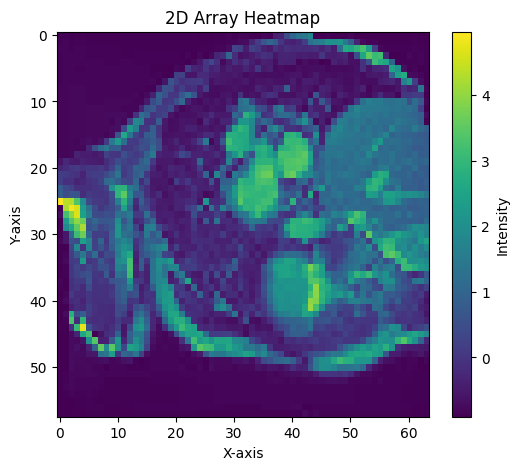

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 创建一个示例的 2D 张量
tensor_2d = torch.rand(10, 10)  # 创建 10x10 的随机张量

# 将 PyTorch 张量转换为 NumPy 数组
array_2d = train_target[0].numpy().squeeze()

# 绘制热力图
plt.figure(figsize=(6, 5))
plt.imshow(array_2d, cmap='viridis', aspect='auto')
plt.colorbar(label='Intensity')
plt.title('2D Array Heatmap')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


In [6]:
import numpy as np
from scipy.sparse import coo_matrix, bmat


def conv_kernel_2_sparse_mat(conv_kernel, height, width):
    # 初始化稀疏矩阵的数据列表
    rows, cols, data = [], [], []
    offsets = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 0), (0, 1), (1, -1), (1, 0), (1, 1)]
    
    for i in range(height):
        for j in range(width):
            img_idx = i * width + j  # 计算当前像素在展平向量中的索引
            
            for k, (di, dj) in enumerate(offsets):
                # 计算卷积核偏移位置的行列索引，使用wrap边界条件
                ni = (i + di) % height
                nj = (j + dj) % width
                neighbor_idx = ni * width + nj  # 相邻像素的展平索引
                
                # 保存索引和卷积核值
                rows.append(img_idx)
                cols.append(neighbor_idx)
                data.append(conv_kernel[di + 1, dj + 1])  # 卷积核值
                
    # 构造稀疏矩阵，形状为 (height * width, height * width)
    conv_sparse_matrix = coo_matrix((data, (rows, cols)), shape=(height * width, height * width))
    return conv_sparse_matrix


def elastic_energy_sparse_matrix(height, width, mu=2, lam=1, delta_height=1, delta_width=1):
    matrix_26 = np.array([
        [0, -(2*mu + lam) * delta_height**-2, 0],
        [-mu * delta_width**-2, mu * (4 * delta_height**-2 + 2 * delta_width**-2) + 2 * lam * delta_height**-2, -mu * delta_width**-2],
        [0, -(2*mu + lam) * delta_height**-2, 0]
    ])
  
    matrix_27 = np.array([
        [-(mu + lam) / 4 * delta_height**-1 * delta_width**-1, 0, (mu + lam) / 4 * delta_height**-1 * delta_width**-1],
        [0, 0, 0],
        [(mu + lam) / 4 * delta_height**-1 * delta_width**-1, 0, -(mu + lam) / 4 * delta_height**-1 * delta_width**-1]
    ])

    matrix_28 = np.array([
        [0, -mu * delta_height**-2, 0],
        [-(2*mu + lam) * delta_width**-2, mu * (4 * delta_width**-2 + 2 * delta_height**-2) + 2 * lam * delta_width**-2, -(2*mu + lam) * delta_width**-2],
        [0, -mu * delta_height**-2, 0]
    ])

    # 将卷积矩阵转换为稀疏矩阵
    matrix_26_sparse = conv_kernel_2_sparse_mat(matrix_26, height, width)
    matrix_27_sparse = conv_kernel_2_sparse_mat(matrix_27, height, width)
    matrix_28_sparse = conv_kernel_2_sparse_mat(matrix_28, height, width)
    
    # 使用 bmat 构造稀疏矩阵 block
    matrix_H = bmat([
        [matrix_28_sparse, matrix_27_sparse],
        [matrix_27_sparse, matrix_26_sparse]
    ], format='coo')
    
    return matrix_H


In [7]:
a = elastic_energy_sparse_matrix(*array_2d.shape).toarray()

In [8]:
import torch

def approximate_hessian(func, inputs, epsilon=1e-7):
    """
    Approximate the Hessian matrix using finite differences.
    func: Forward pass function that computes the loss.
    inputs: Tensor to compute the Hessian for.
    epsilon: Perturbation size.
    """
    # Compute the initial gradient
    initial_grad = torch.autograd.grad(func(inputs), inputs, create_graph=True)[0]

    length_x = inputs.numel() // 2

    perturbed_inputs = inputs.clone()

    # Perturb the first half of the inputs
    perturbed_inputs.view(-1)[:length_x] += epsilon

    # Compute the perturbed gradients
    perturbed_grad = torch.autograd.grad(func(perturbed_inputs), perturbed_inputs, create_graph=True)[0]

    # Compute the Hessian for the first block (A)
    hessian_column_x = (perturbed_grad - initial_grad).view(-1) / epsilon

    perturbed_inputs = inputs.clone()

    # Perturb the second half of the inputs
    perturbed_inputs.view(-1)[length_x:] += epsilon

    # Compute the perturbed gradients
    perturbed_grad = torch.autograd.grad(func(perturbed_inputs), perturbed_inputs, create_graph=True)[0]

    # Compute the Hessian for the second block (D)
    hessian_column_y = (perturbed_grad - initial_grad).view(-1) / epsilon

    # Now we want to form the block diagonal Hessian matrix:
    # Block structure: 
    # [Diag(A), Diag(C); Diag(B), Diag(D)]
    A = hessian_column_x[:length_x]
    B = hessian_column_x[length_x:]
    C = hessian_column_y[:length_x]
    D = hessian_column_y[length_x:]

    # Create the block diagonal Hessian matrix
    hessian_matrix = torch.zeros(2 * length_x, 2 * length_x, device=inputs.device)

    # Diagonal blocks (A, D) on the diagonal
    hessian_matrix[:length_x, :length_x] = torch.diag(A)
    hessian_matrix[length_x:, length_x:] = torch.diag(D)

    # Off-diagonal blocks (B, C)
    hessian_matrix[:length_x, length_x:] = torch.diag(B)
    hessian_matrix[length_x:, :length_x] = torch.diag(C)

    hessian_matrix = (hessian_matrix + hessian_matrix.t()) / 2
    return hessian_matrix


In [9]:
from register.SpatialTransformer2 import SpatialTransformer2
## 判断a是不是numpy
if isinstance(a,np.ndarray):
     a=torch.from_numpy(a).float()  # 转换为tensor
     device=torch.device("cuda:3")  # 使用GPU
choose_index = 1
model=SpatialTransformer2(train_input[:choose_index].shape[2:],10)  # 生成模型
train_image=train_input[:choose_index].to(device)
test_image=train_target[:choose_index].to(device)
model=model.to(device)
a = a.to(device)
loss_fn=nn.MSELoss(reduction='sum')   # MSE作为loss
basic_flow_shape = model.basic_flows.shape

## 超参数
eta = 2
eye_matrix = eta * torch.eye(2 * train_image.numel()).to(device)

In [10]:
from register.SpatialTransformer2 import SpatialTransformer2
all_loss_list = []
## 判断a是不是numpy
for eta in [0.5,1,5,10,20]:
    if isinstance(a,np.ndarray):
        a=torch.from_numpy(a).float()  # 转换为tensor
        device=torch.device("cuda:3")  # 使用GPU
    choose_index = 1
    model=SpatialTransformer2(train_input[:choose_index].shape[2:],10)  # 生成模型
    train_image=train_input[:choose_index].to(device)
    test_image=train_target[:choose_index].to(device)
    model=model.to(device)
    a = a.to(device)
    loss_fn=nn.MSELoss(reduction='sum')   # MSE作为loss
    basic_flow_shape = model.basic_flows.shape

    ## 超参数

    eye_matrix = eta * torch.eye(2 * train_image.numel()).to(device)
    loss_list = []
    t = track(range(1000), leave=False, desc="Epoch iteration")
    for i in  t:
        loss=loss_fn(model(train_image), test_image)   # 计算loss
        if hasattr(t, "set_description"):
                t.set_description("Model update loop, loss: %4.2f" % (loss/train_image.numel()))

        loss.backward(retain_graph=True)
        loss_list.append(loss.item()/train_image.numel())
        grad = model.basic_flows.grad.view(-1, 1)
        def hessian_forward(flows):
            loss = loss_fn(model(train_image,flows), test_image) /2
            return loss

        hess = approximate_hessian(hessian_forward, model.basic_flows)
        # print(hess.sum())
        with torch.no_grad():
            model.basic_flows.data  = (model.basic_flows.view(-1,1) - torch.linalg.solve(a+hess+eye_matrix, grad + a @ model.basic_flows.view(-1, 1))).view(*basic_flow_shape)
    all_loss_list.append(loss_list)

Epoch iteration:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch iteration:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch iteration:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch iteration:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch iteration:   0%|          | 0/1000 [00:00<?, ?it/s]

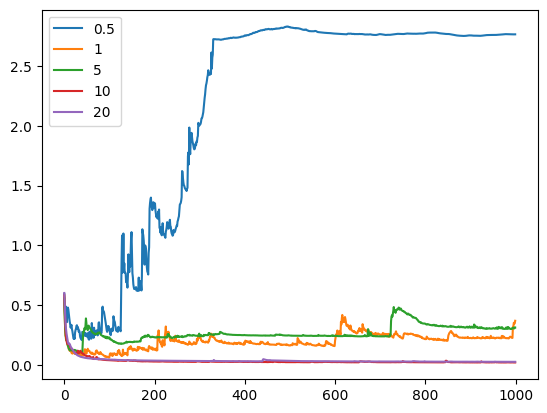

In [11]:
for loss_list in all_loss_list:
    plt.plot(loss_list)
plt.legend([0.5,1,5,10,20])
plt.show()


In [15]:
predict_image=model(train_image) 

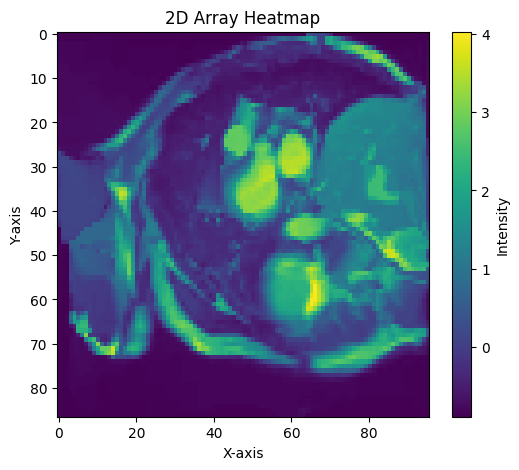

tensor(868.7390, device='cuda:3', grad_fn=<MseLossBackward0>)

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 创建一个示例的 2D 张量
tensor_2d = torch.rand(10, 10)  # 创建 10x10 的随机张量

# 将 PyTorch 张量转换为 NumPy 数组

# 绘制热力图
plt.figure(figsize=(6, 5))
plt.imshow(predict_image.squeeze().cpu().detach().numpy(), cmap='viridis', aspect='auto')
plt.colorbar(label='Intensity')
plt.title('2D Array Heatmap')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()
loss

## Adam Batch

In [5]:
from register.SpatialTransformer2 import SpatialTransformer2
model=SpatialTransformer2(train_input.shape[2:],7)

device=torch.device("cuda:3")
# model.load_state_dict(torch.load('./data/circle2C/model/loss_0.0009_model.pth'))
train_input=train_input.to(device)
train_target=train_target.to(device)
model=model.to(device)

# opt = torch.optim.SGD(model.parameters(), lr=32)
opt=torch.optim.Adam(model.parameters(), lr=0.05)
loss_fn=nn.MSELoss()

from register.LocalDisplacementEnergy import BendingEnergy
bending_energy = BendingEnergy(alpha=128, dimension=2)

losses_with_regularization = []
losses_without_regularization = []
num_images=10
for epoch in range(20000):
    total_loss_with_reg = 0.0
    total_loss_without_reg = 0.0

    for i in range(num_images):
        # 获取单张图片
        input_image = train_input[i].unsqueeze(0)
        target_image = train_target[i].unsqueeze(0)

        # 计算损失函数的均值
        pred = model(input_image)
        loss = loss_fn(pred, target_image)
        total_loss_with_reg += (loss + bending_energy([flows for flows in model.parameters()][0]))
        total_loss_without_reg += loss

    # 计算均值
    mean_loss_with_reg = total_loss_with_reg / num_images
    mean_loss_without_reg = total_loss_without_reg / num_images

    if (epoch + 1) % 200 == 0:
        print(epoch + 1, "loss (with reg): ", mean_loss_with_reg.item(), "loss (without reg): ", mean_loss_without_reg.item())

    losses_with_regularization.append(mean_loss_with_reg.item())
    losses_without_regularization.append(mean_loss_without_reg.item())

    # 反向传播和优化
    opt.zero_grad()
    mean_loss_with_reg.backward(retain_graph=True)
    opt.step()

200 loss (with reg):  0.5082478523254395 loss (without reg):  0.42597314715385437
400 loss (with reg):  0.4261685907840729 loss (without reg):  0.4065719246864319
600 loss (with reg):  0.3963701128959656 loss (without reg):  0.38504236936569214
800 loss (with reg):  0.3733445107936859 loss (without reg):  0.3637629449367523
1000 loss (with reg):  0.35343673825263977 loss (without reg):  0.34408387541770935
1200 loss (with reg):  0.3321983218193054 loss (without reg):  0.3217715919017792
1400 loss (with reg):  0.31000640988349915 loss (without reg):  0.2982605993747711
1600 loss (with reg):  0.2888287305831909 loss (without reg):  0.2758716344833374
1800 loss (with reg):  0.26871511340141296 loss (without reg):  0.25481244921684265
2000 loss (with reg):  0.25048360228538513 loss (without reg):  0.23584942519664764
2200 loss (with reg):  0.23345819115638733 loss (without reg):  0.21820364892482758
2400 loss (with reg):  0.21719376742839813 loss (without reg):  0.2014116495847702
2600 los

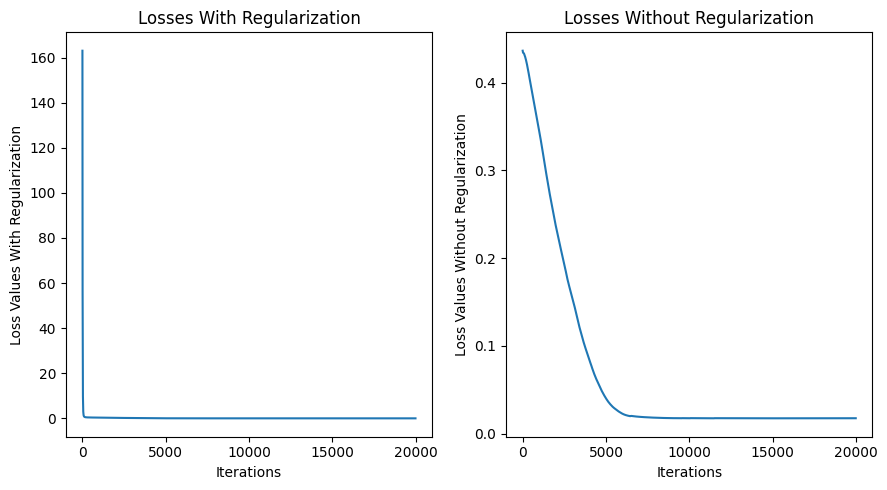

In [9]:
import matplotlib.pyplot as plt
import numpy as np


iterations = np.arange(0, 20000,10)
losses_with_reg_values = np.array(losses_with_regularization[:20000:10])
losses_without_reg_values = np.array(losses_without_regularization[:20000:10])

# 绘制折线图
plt.figure(figsize=(9, 5))

# 折线图
plt.subplot(1, 2, 1)
plt.plot(iterations, losses_with_reg_values, label='With Regularization')
# plt.plot(iterations, losses_without_reg_values, label='Without Regularization')
plt.title('Losses With Regularization')
plt.xlabel('Iterations')
plt.ylabel('Loss Values With Regularization')
# plt.legend()

plt.subplot(1, 2, 2)
# plt.plot(iterations, losses_with_reg_values, label='With Regularization')
plt.plot(iterations, losses_without_reg_values, label='Without Regularization')
plt.title('Losses Without Regularization')
plt.xlabel('Iterations')
plt.ylabel('Loss Values Without Regularization')
# plt.legend()


plt.tight_layout()
plt.show()


In [10]:
torch.save(model.state_dict(), './data/FFD/model/best_model_name.pth')
np.save('./data/FFD/model/loss_with_reg_name.npy', np.array(losses_with_regularization))
np.save('./data/FFD/model/loss_without_reg_name.npy', np.array(losses_without_regularization))

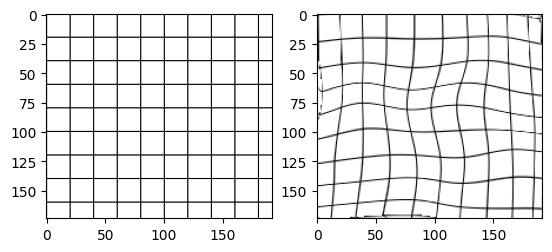

In [17]:
import matplotlib.pyplot as plt
lattice=np.ones((174,192))
lattice[::20,:]=0
lattice[:,::20]=0
lattice=lattice*255
model.load_state_dict(torch.load('./data/FFD/model/best_model.pth'))
norm_lattice = z_score_normalize(torch.from_numpy(np.array(lattice)).float().unsqueeze(0).unsqueeze(0))
warped_norm_lattice=model(norm_lattice.to(device)).squeeze().cpu().detach().numpy().squeeze()

plt.subplot(1,2,1)
plt.imshow(lattice,cmap='gray')

plt.subplot(1,2,2)
warped_norm_lattice=(warped_norm_lattice-np.min(warped_norm_lattice))/(np.max(warped_norm_lattice)-np.min(warped_norm_lattice))*255
image=Image.fromarray(warped_norm_lattice.astype(np.uint8))
image.save('./data/FFD/output/warped_norm_lattice.png')
plt.imshow(warped_norm_lattice, cmap='gray')
plt.show()

In [19]:
loss1=[]
for i in range(10):
    loss1.append(loss_fn(model(train_input[i,...].unsqueeze(0)), train_target[i,...].unsqueeze(0)))
    output=model(train_input[i,...].unsqueeze(0)).cpu().detach().numpy().squeeze()
    output=(output-np.min(output))/(np.max(output)-np.min(output))*255
    image=Image.fromarray(output.astype(np.uint8))
    image.save(f'./data/FFD/output/train_image_{i}.png')
sum(loss1)/10

tensor(0.0175, device='cuda:3', grad_fn=<DivBackward0>)

另一张切片测试

In [14]:
# 1. Load image
source_image0 = Image.open('./data/FFD/image/test_floating_img.jpg').convert('L')
target_image0 = Image.open('./data/FFD/image/test_reference_img.jpg').convert('L')
input0=torch.from_numpy(np.array(source_image0)).float().unsqueeze(0).unsqueeze(0)
target0=torch.from_numpy(np.array(target_image0)).float().unsqueeze(0).unsqueeze(0)
print("input.shape: ", input0.shape)
print("target.shape: ", target0.shape)

input.shape:  torch.Size([1, 1, 174, 192])
target.shape:  torch.Size([1, 1, 174, 192])


tensor(0.0945, device='cuda:3', grad_fn=<MseLossBackward0>)


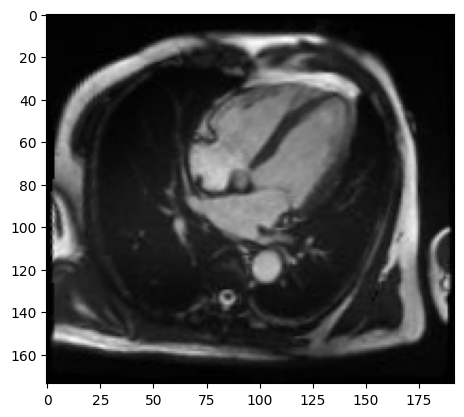

In [18]:
input0 = z_score_normalize(input0)
target0 = z_score_normalize(target0)
print(loss_fn(model(input0.to(device)), target0.to(device)))

output=model(input0.to(device)).cpu().detach().numpy().squeeze()
output=(output-np.min(output))/(np.max(output)-np.min(output))*255
image=Image.fromarray(output.astype(np.uint8))
image.save('./data/FFD/output/test_image.png')
plt.imshow(output, cmap='gray')
plt.show()